# Project 4: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### Load Packages

In [2]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_tests
import project_helper

import warnings
import matplotlib.pyplot as plt

In [3]:
# hide warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [4]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


### CLI

ZIPLINE_ROOT=$(pwd)/../../data/project_4_eod

echo $ZIPLINE_ROOT

zipline bundles

zipline ingest --bundle csvdir

## Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [5]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

# take first 100 of stocks which have highest average daily volumne to reduce volatility 
# as the universe of stocks to start working on
universe = AverageDollarVolume(window_length=120).top(100)

# in order to backtest your strategy, the dates in data bundle and the dates in selected TradingCalendar 
# should match up, they hold for both minutely and daily data
# calendars use UTC, started from midnight 
# using NYSE trading calendar in this case
trading_calendar = get_calendar('NYSE') 

# load data from csv to memory and stored in bundle_data variable
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)

# ask helper to construct pipeline engine to execute next
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [6]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

# run_pipeline() returns 2 level index pandas dataframe
universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(17 [AET]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(35 [AMGN]),
 Equity(38 [AMZN]),
 Equity(41 [ANTM]),
 Equity(45 [APC]),
 Equity(52 [AVGO]),
 Equity(55 [AXP]),
 Equity(58 [BA]),
 Equity(59 [BAC]),
 Equity(66 [BIIB]),
 Equity(70 [BMY]),
 Equity(74 [C]),
 Equity(78 [CAT]),
 Equity(85 [CELG]),
 Equity(98 [CMCSA]),
 Equity(100 [CMG]),
 Equity(109 [COP]),
 Equity(110 [COST]),
 Equity(114 [CSCO]),
 Equity(121 [CVS]),
 Equity(122 [CVX]),
 Equity(124 [D]),
 Equity(125 [DAL]),
 Equity(132 [DIS]),
 Equity(147 [EBAY]),
 Equity(155 [EOG]),
 Equity(160 [ESRX]),
 Equity(173 [FB]),
 Equity(175 [FCX]),
 Equity(176 [FDX]),
 Equity(188 [FOXA]),
 Equity(192 [GE]),
 Equity(194 [GILD]),
 Equity(198 [GOOG]),
 Equity(199 [GOOGL]),
 Equity(204 [GS]),
 Equity(207 [HAL]),
 Equity(214 [HD]),
 Equity(220 [HON]),
 Equity(231 [IBM]),
 Equity(235 [ILMN]),
 Equity(238 [INTC]),
 Equity(251 [JNJ]),
 Equity(253 [JPM]),
 Equity(261 [KM

In [7]:
len(universe_tickers)

100

In [8]:
# save intermediate data
# np.savetxt('universe_tickers.csv', universe_tickers, delimiter =', ', fmt ='% s')

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [9]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,  # AssetFinder instance used to resolve assets
    trading_calendar=trading_calendar,  # calendar instance used to provide minute->session information
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,  # first trading day for the simulation
    equity_minute_reader=None,  # minute bar reader for equities. This will be used to service minute data backtests or minute history calls
    equity_daily_reader=bundle_data.equity_daily_bar_reader,  # daily bar reader for equities. This will be used to service daily data backtests or daily history calls in a minute backetest
    adjustment_reader=bundle_data.adjustment_reader  # adjustment reader used to apply splits, dividends, and other adjustment data to the raw data from the readers
)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [10]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # returns a pandas dataframe containing the requested history window. Data is fully adjusted.
    return data_portal.get_history_window(
        assets=assets,  # assets whose data is desired
        end_dt=end_dt,  # end time
        bar_count=end_loc - start_loc,  # number of bars desired
        frequency='1d',  # “1d” or “1m”
        field=field,  # desired field of the asset
        data_frequency='daily'  # frequency of the data to query; i.e. whether the data is ‘daily’ or ‘minute’ bars
    )

### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [11]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)  # Computes the percentage change from the immediately previous row, remove first row since it has no data

five_year_returns

,Equity(0 [A]),Equity(1 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(17 [AET]),Equity(19 [AGN]),Equity(20 [AIG]),Equity(35 [AMGN]),Equity(38 [AMZN]),Equity(41 [ANTM]),...,Equity(448 [UPS]),Equity(450 [USB]),Equity(451 [UTX]),Equity(452 [V]),Equity(456 [VLO]),Equity(465 [WBA]),Equity(468 [WFC]),Equity(472 [WMB]),Equity(473 [WMT]),Equity(483 [XOM])
2011-01-07 00:00:00+00:00,0.00843652,0.01423027,0.00714639,0.00000000,0.00214958,0.01563734,0.01208582,0.00755902,-0.00199075,0.01579168,...,-0.00469080,-0.00759219,-0.00087451,-0.00289084,0.00213459,-0.00596751,-0.02020662,0.01586060,0.00222742,0.00546091
2011-01-10 00:00:00+00:00,-0.00417428,0.00619534,0.01885158,0.00000000,0.00187260,0.01576594,-0.06194784,-0.00942913,-0.00436681,0.01108298,...,-0.00013811,0.00610200,-0.00784728,-0.01577177,-0.00420404,0.02171540,-0.00953636,-0.00679129,-0.00648782,-0.00608100
2011-01-11 00:00:00+00:00,-0.00188630,-0.04364361,-0.00236744,0.00000000,0.01491878,-0.01289927,0.02874975,-0.00442835,-0.00184102,0.01211143,...,-0.00540419,-0.00760387,0.00587117,0.00100153,0.01812553,-0.00292381,0.00641879,0.02502467,0.01043926,0.00744242
2011-01-12 00:00:00+00:00,0.01725375,-0.00823708,0.00813289,0.00000000,0.00334840,-0.01289334,-0.01084124,0.01174368,-0.00141044,0.00097125,...,0.00279490,0.02458269,0.00645688,0.01012301,0.01653121,0.00905092,0.01944466,0.02049378,0.01030905,0.01176334
2011-01-13 00:00:00+00:00,-0.00455851,0.00095465,0.00365656,0.00000000,-0.00030035,0.00441939,-0.02072447,-0.00932698,0.00787701,-0.00194061,...,0.00417200,0.00222568,0.00088644,-0.02021791,0.01958012,0.01067427,-0.00377661,0.02432778,-0.00108457,0.00169383
2011-01-14 00:00:00+00:00,0.00343886,-0.00915594,0.00810620,0.00000000,0.03321538,-0.00840878,-0.05577914,0.00319356,0.01735568,0.02815687,...,0.00317203,0.02318454,-0.00528394,-0.00029734,-0.00202710,-0.00481075,0.02699598,-0.00223684,0.00035453,0.01474258
2011-01-18 00:00:00+00:00,0.03425353,-0.06208490,-0.02247419,0.00000000,0.00798036,0.02928590,-0.01537320,0.01399454,0.01324503,-0.00913454,...,0.00745820,-0.00221383,0.00618728,0.00124918,0.02325208,0.01280733,-0.00794183,-0.00797837,0.00602490,0.01116324
2011-01-19 00:00:00+00:00,-0.01022379,-0.00892857,-0.00531448,0.00000000,-0.02839926,-0.01778050,-0.04044359,-0.00542271,-0.02290196,-0.01444030,...,-0.01151386,-0.02888715,0.00427447,-0.02934886,-0.03092514,-0.01645820,-0.02093434,-0.00837488,-0.00200361,-0.00596800
2011-01-20 00:00:00+00:00,-0.00849568,0.02195299,-0.01818900,0.00000000,-0.00511349,0.00819288,0.00854116,0.00580073,-0.02627495,-0.00805671,...,0.00666091,0.00676463,-0.00449522,0.02270780,-0.02824646,0.00800424,0.00249520,0.00348549,0.01745097,-0.00626137
2011-01-21 00:00:00+00:00,0.00787281,-0.04103759,-0.01791080,0.00000000,0.00785887,0.02308258,-0.00417159,-0.00593030,-0.02495054,-0.00178650,...,0.00315414,0.00974503,0.00816094,-0.00760069,0.00205248,0.00193675,0.01945242,0.01068733,-0.00464027,0.01582494


In [12]:
five_year_returns.shape

(1256, 100)

In [13]:
# save intermediate data
# five_year_returns.to_csv('five_year_returns.csv')

# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [14]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    
    #TODO: Implement function
    pca = PCA(
        n_components=num_factor_exposures,  # number of components to keep
        svd_solver=svd_solver  # Singular Value Decomposition: "full" - run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing
    )
        
    pca.fit(returns)
    
    return pca


project_tests.test_fit_pca(fit_pca)

Tests Passed


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [15]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

Once the `PCA()` class fits the data through the `.fit()` method it returns an array containing the principal components in the attribute `.components_`, and the corresponding eigenvalues in a 1D array in the attribute `.singular_values_`. Other attributes of the `PCA()` class include `.explained_variance_ratio_` which gives the percentage of variance explained by each of the principal components. In the code below we access the above attributes and display their contents

In [16]:
# Principal axes in feature space, representing the directions of maximum variance in the data. 
print('\nArray Containing all Principal Components:\n', pca.components_)
print('\nFirst Principal Component:', pca.components_[0])
print('Second Principal Component:', pca.components_[1])

# Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors.
print('\nEigenvalues:', pca.singular_values_)

# The components are sorted by explained_variance_
print('\nPercentage of Variance Explained by Each Principal Component:', pca.explained_variance_ratio_)


Array Containing all Principal Components:
 [[-0.09390915 -0.14241861 -0.07747254 ... -0.12208613 -0.04341845
  -0.08235514]
 [-0.00141095  0.42751861 -0.01472977 ... -0.10592488  0.01573087
  -0.0880838 ]
 [-0.03306102 -0.09475745 -0.0081233  ... -0.00712792 -0.02863536
  -0.02144764]
 ...
 [-0.04390045  0.34056534  0.12269716 ...  0.53033968  0.01424006
   0.00653503]
 [-0.09362043  0.06056035  0.05270297 ... -0.01115415 -0.05336193
  -0.00289345]
 [-0.16290866 -0.14091174  0.03938474 ...  0.31157337 -0.03009171
  -0.02230135]]

First Principal Component: [-0.09390915 -0.14241861 -0.07747254 -0.04308033 -0.09124586 -0.08158817
 -0.13014803 -0.08328771 -0.10290387 -0.08488123 -0.13464575 -0.12826204
 -0.09584476 -0.09390915 -0.15233859 -0.10266393 -0.06688465 -0.15442326
 -0.11354688 -0.10355731 -0.08823404 -0.08310873 -0.0933717  -0.05874296
 -0.09005024 -0.06984537 -0.09206275 -0.09603444 -0.12715758 -0.09360219
 -0.10795718 -0.13027158 -0.08108199 -0.05192024 -0.15995741 -0.101246

In [17]:
pca.components_.shape

(20, 100)

In [18]:
# save intermediate data
# np.savetxt('pca.components_.csv', pca.components_, delimiter =', ', fmt ='% s')

In [19]:
pca.explained_variance_ratio_.shape

(20,)

In [20]:
# save intermediate data
# np.savetxt('pca.explained_variance_ratio_.csv', pca.explained_variance_ratio_, delimiter =', ', fmt ='% s')

Let's also look at the PCA's percent of variance explained by each factor

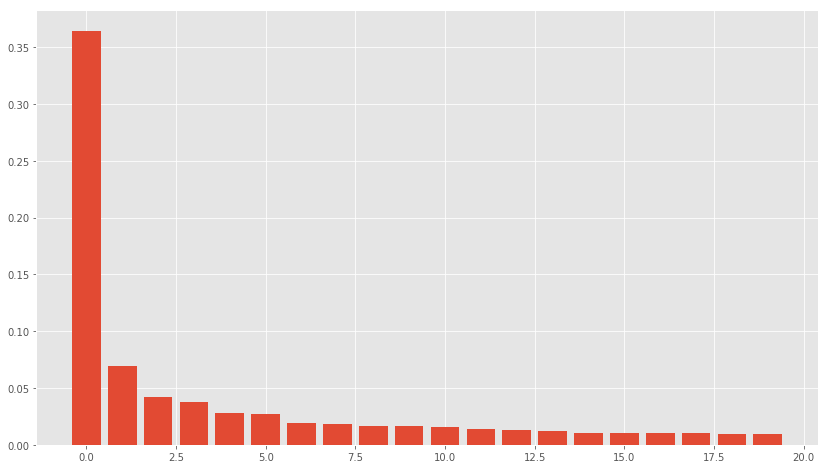

In [21]:
# The amount of variance explained by each of the selected components. 
# The variance estimation uses n_samples - 1 degrees of freedom.
# Equal to n_components largest eigenvalues of the covariance matrix of X
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);

You will see that the first factor dominates. The dominant factor is usually interpreted as "the market", whereas the remaining factors can be interpreted as industry or style factors.

The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas aka Factor Exposures

Implement `factor_betas` to get the factor betas from the PCA model.

In [22]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    #TODO: Implement function
    return pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)


project_tests.test_factor_betas(factor_betas)

Tests Passed


### View Data
Let's view the factor betas from this model.

In [23]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.09390915,-0.00141095,-0.03306102,-0.00660760,0.05195139,-0.05767347,-0.00377557,-0.01914868,-0.06539902,-0.01350727,-0.00278910,0.03765576,-0.02794516,-0.01093574,0.06827213,0.03079699,0.00810562,-0.04390045,-0.09362043,-0.16290866
Equity(1 [AAL]),-0.14241861,0.42751861,-0.09475745,0.21464951,0.00857556,0.15551197,0.04822654,0.04120075,-0.02788746,-0.01168251,-0.01960054,-0.04903741,0.04682129,0.11947564,0.22992038,-0.37177326,0.26165103,0.34056534,0.06056035,-0.14091174
Equity(3 [AAPL]),-0.07747254,-0.01472977,-0.00812330,-0.00896605,-0.13051918,-0.07600582,0.02425412,0.08474551,-0.10354503,-0.03378482,-0.04840198,0.08108987,-0.05102529,0.07292245,0.14489277,-0.04552683,-0.04101146,0.12269716,0.05270297,0.03938474
Equity(4 [ABBV]),-0.04308033,0.02003744,0.01367357,-0.10221187,0.02328343,0.01436344,-0.03493178,-0.06029539,-0.07371052,0.07168798,-0.04652754,0.00834995,0.09760431,0.02431833,-0.03465391,0.07613138,-0.11310586,0.07026129,-0.08721462,0.08972496
Equity(17 [AET]),-0.09124586,0.00653752,-0.00687966,-0.05548829,0.07693490,-0.04902455,0.07455441,-0.05913954,-0.15636163,0.06789918,0.10304234,-0.15636673,0.26040618,0.07873579,-0.06983562,-0.14758502,0.02511764,-0.15132978,0.35120106,0.10582869
Equity(19 [AGN]),-0.08158817,0.04106977,0.00321719,-0.15187652,0.01279223,0.03674899,0.00117797,-0.03894987,-0.05120141,0.08463837,0.09428811,-0.05750460,0.09544117,0.06259216,-0.00323742,0.11191318,-0.08192199,0.03237080,-0.04774725,0.06340059
Equity(20 [AIG]),-0.13014803,-0.01526811,-0.04340195,0.03602990,0.07458199,-0.06285514,0.07373119,0.01178805,0.10990893,-0.10808919,-0.01258980,-0.05968554,0.02156667,0.00778542,0.01951410,-0.04238426,-0.03175471,-0.00175676,-0.01906143,-0.01128679
Equity(35 [AMGN]),-0.08328771,0.03480748,-0.03362059,-0.18460562,0.02902135,0.03030330,-0.05849542,-0.09419196,-0.02089735,-0.01070806,-0.04184603,-0.00610987,0.03199999,-0.04765212,-0.02695661,0.02950657,-0.04318366,0.04874314,-0.05034030,-0.03021726
Equity(38 [AMZN]),-0.10290387,0.02925274,0.11749999,-0.09071177,-0.02545058,-0.07412816,-0.05933227,0.19952920,0.01388421,0.07209631,0.00899343,0.09539410,-0.24670096,-0.20913234,0.28614563,-0.21854301,-0.20723723,-0.25934995,0.15120852,0.32139564
Equity(41 [ANTM]),-0.08488123,0.00251418,-0.00589528,-0.04772552,0.06892129,-0.06954861,0.05648041,-0.06039955,-0.11471034,0.04306789,0.10038512,-0.16374680,0.24966328,0.02836631,-0.05363157,-0.13648472,0.06656921,-0.13467688,0.32640696,0.08557187


In [24]:
risk_model['factor_betas'].shape

(100, 20)

In [25]:
# save intermediate data
# risk_model['factor_betas'].to_csv('factor_betas.csv')

## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [26]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    #TODO: Implement function
    return pd.DataFrame(
        pca.transform(returns),  # Apply dimensionality reduction to the "returns"
        index=factor_return_indices, 
        columns=factor_return_columns
    )


project_tests.test_factor_returns(factor_returns)

Tests Passed


### View Data
Let's see what these factor returns looks like over time.

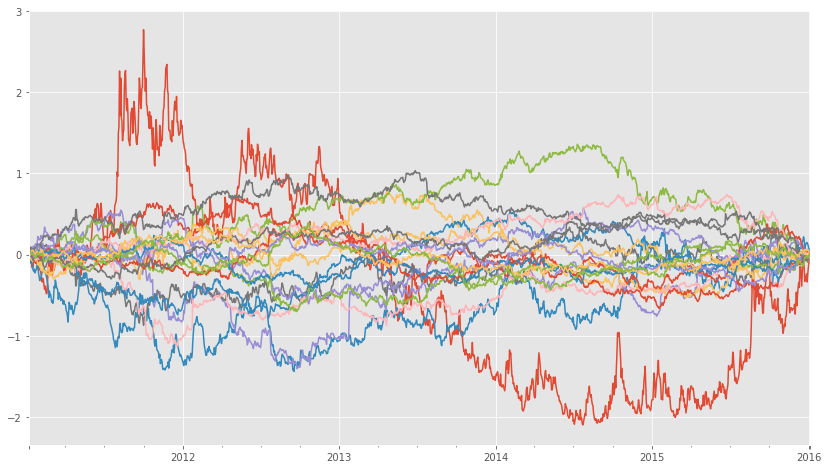

In [27]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None);

In [28]:
risk_model['factor_returns'].shape

(1256, 20)

#### Student Notes

Number of features have been reduced from 100 down to 20 which are top influent ones

In [29]:
# save intermediate data
# risk_model['factor_returns'].to_csv('factor_returns.csv')

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [30]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    #TODO: Implement function
    return np.diag(  # Construct a diagonal array
        factor_returns.var(axis=0, ddof=1)  # Return unbiased variance over columns with 1 Delta Degrees of Freedom
        * ann_factor
    )


project_tests.test_factor_cov_matrix(factor_cov_matrix)

Tests Passed


### View Data

In [31]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[2.90677284, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.55439398, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33201603, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.29872551, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

In [32]:
risk_model['factor_cov_matrix'].shape

(20, 20)

In [33]:
# save intermediate data
# np.savetxt('factor_cov_matrix.csv', risk_model['factor_cov_matrix'], delimiter =', ', fmt ='% s')

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [34]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    #TODO: Implement function
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals_ = (returns - common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_)) * ann_factor, returns.columns, returns.columns)


project_tests.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

Tests Passed


### View Data

In [35]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(17 [AET]),Equity(19 [AGN]),Equity(20 [AIG]),Equity(35 [AMGN]),Equity(38 [AMZN]),Equity(41 [ANTM]),...,Equity(448 [UPS]),Equity(450 [USB]),Equity(451 [UTX]),Equity(452 [V]),Equity(456 [VLO]),Equity(465 [WBA]),Equity(468 [WFC]),Equity(472 [WMB]),Equity(473 [WMT]),Equity(483 [XOM])
Equity(0 [A]),0.01991963,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.01465826,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.04019852,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.02938356,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(17 [AET]),0.00000000,0.00000000,0.00000000,0.00000000,0.01329213,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(19 [AGN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03769223,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(20 [AIG]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03145918,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(35 [AMGN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02350526,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(38 [AMZN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02094344,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(41 [ANTM]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01294378,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [36]:
risk_model['idiosyncratic_var_matrix'].shape

(100, 100)

In [37]:
# save intermediate data
# risk_model['idiosyncratic_var_matrix'].to_csv('idiosyncratic_var_matrix.csv')

## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [38]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
    return pd.DataFrame(np.diag(idiosyncratic_var_matrix), index=returns.columns)


project_tests.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

Tests Passed


### View Data

In [39]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.01991963
Equity(1 [AAL]),0.01465826
Equity(3 [AAPL]),0.04019852
Equity(4 [ABBV]),0.02938356
Equity(17 [AET]),0.01329213
Equity(19 [AGN]),0.03769223
Equity(20 [AIG]),0.03145918
Equity(35 [AMGN]),0.02350526
Equity(38 [AMZN]),0.02094344
Equity(41 [ANTM]),0.01294378


In [40]:
risk_model['idiosyncratic_var_vector'].shape

(100, 1)

In [41]:
# save intermediate data
# risk_model['idiosyncratic_var_vector'].to_csv('idiosyncratic_var_vector.csv')

## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [42]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    predicted_portfolio_risk = np.sqrt(
        weights.T.\
        dot(
            factor_betas\
            .dot(factor_cov_matrix)\
            .dot(factor_betas.T) + 
            idiosyncratic_var_matrix)\
        .dot(weights)
    )
    
    # print(f'predicted_portfolio_risk in type {type(predicted_portfolio_risk)}:\n', predicted_portfolio_risk)
    return predicted_portfolio_risk.iloc[0, 0]

project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

Tests Passed


### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [43]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.16347683770247895

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [44]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers (underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [45]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    #TODO: Implement function
    # the minus sign indicates reversion since the sorting is in ascending by default
    # we need it in descending order
    return -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()


project_tests.test_mean_reversion_5day_sector_neutral(mean_reversion_5day_sector_neutral)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [46]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral'
)

mean_reversion_5day_sector_neutral_df = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

In [47]:
mean_reversion_5day_sector_neutral_df

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                               0.94480319
                          Equity(1 [AAL])                             1.53967927
                          Equity(3 [AAPL])                            1.15475945
                          Equity(4 [ABBV])                            1.43470114
                          Equity(6 [ABT])                             0.10497813
                          Equity(7 [ACN])                             0.80483234
                          Equity(8 [ADBE])                           -0.10497813
                          Equity(19 [AGN])                           -1.46969385
                          Equity(20 [AIG])                            0.83982505
                          Equity(35 [AMGN])                          -1.36471571
                          Equity(37 [AMT])                           -0.52489066
                          Equity(38 [AMZN])                           1.25973758
                          Equity(44 [APA])                            0.41991253
                          Equity(45 [APC])                           -1.25973758
                          Equity(55 [AXP])                           -0.59487608
                          Equity(58 [BA])                             0.17496355
                          Equity(59 [BAC])                           -1.67965011
                          Equity(66 [BIIB])                           0.20995626
                          Equity(70 [BMY])                            1.32972300
                          Equity(74 [C])                              0.52489066
                          Equity(78 [CAT])                            0.62986879
                          Equity(82 [CBS])                           -0.69985421
                          Equity(85 [CELG])                          -1.53967927
                          Equity(90 [CHK])                            1.60966469
                          Equity(98 [CMCSA])                          0.38491982
                          Equity(109 [COP])                          -0.24494897
                          Equity(113 [CRM])                          -0.80483234
                          Equity(114 [CSCO])                         -1.57467198
                          Equity(121 [CVS])                           0.97979590
                          Equity(122 [CVX])                          -0.38491982
...                                                                          ...
2016-01-05 00:00:00+00:00 Equity(344 [OXY])                           0.68932141
                          Equity(351 [PEP])                           0.37117307
                          Equity(352 [PFE])                          -0.72467123
                          Equity(361 [PM])                            0.26512362
                          Equity(374 [PXD])                          -1.46701737
                          Equity(375 [PYPL])                          1.29026829
                          Equity(376 [QCOM])                         -1.60841663
                          Equity(381 [REGN])                          1.50236718
                          Equity(395 [SBUX])                         -0.33582325
                          Equity(397 [SCHW])                         -0.12372436
                          Equity(402 [SLB])                           1.32561810
                          Equity(417 [SWKS])                         -0.30047344
                          Equity(422 [T])                            -0.37117307
                          Equity(426 [TGT])                          -1.39631774
                          Equity(437 [TWX])                          -1.67911626
                          Equity(438 [TXN])                           1.36096792
                          Equity(440 [UAA])                          -1.07816939
                          Equity(441 [UAL])                           1.64376

In [48]:
# save intermediate data
# mean_reversion_5day_sector_neutral_df.to_csv('mean_reversion_5day_sector_neutral_df.csv')

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [49]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    #TODO: Implement function
    mean_reversion = mean_reversion_5day_sector_neutral(window_length, universe, sector)

    return SimpleMovingAverage(inputs=[mean_reversion], window_length=window_length) \
        .rank() \
        .zscore()


project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral_smoothed(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the smoothed data looks like.

In [50]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed'
)

mean_reversion_5day_sector_neutral_smoothed_df = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

In [51]:
mean_reversion_5day_sector_neutral_smoothed_df

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                        0.97979590
                          Equity(1 [AAL])                                      1.71464282
                          Equity(3 [AAPL])                                     0.90981048
                          Equity(4 [ABBV])                                     0.94480319
                          Equity(6 [ABT])                                      0.76983963
                          Equity(7 [ACN])                                     -0.55988337
                          Equity(8 [ADBE])                                     0.73484692
                          Equity(19 [AGN])                                    -0.17496355
                          Equity(20 [AIG])                                     1.01478861
                          Equity(35 [AMGN])                                   -1.01478861
                          Equity(37 [AMT])                                    -0.10497813
                          Equity(38 [AMZN])                                    1.04978132
                          Equity(44 [APA])                                     1.36471571
                          Equity(45 [APC])                                     0.31493440
                          Equity(55 [AXP])                                    -1.39970842
                          Equity(58 [BA])                                      0.48989795
                          Equity(59 [BAC])                                     0.87481777
                          Equity(66 [BIIB])                                    1.43470114
                          Equity(70 [BMY])                                     1.50468656
                          Equity(74 [C])                                       1.15475945
                          Equity(78 [CAT])                                    -0.87481777
                          Equity(82 [CBS])                                    -1.57467198
                          Equity(85 [CELG])                                   -0.76983963
                          Equity(90 [CHK])                                     1.29473029
                          Equity(98 [CMCSA])                                  -0.66486150
                          Equity(109 [COP])                                    0.41991253
                          Equity(113 [CRM])                                   -0.59487608
                          Equity(114 [CSCO])                                  -1.64465740
                          Equity(121 [CVS])                                   -0.38491982
                          Equity(122 [CVX])                                   -0.06998542
...                                                                                   ...
2016-01-05 00:00:00+00:00 Equity(344 [OXY])                                    0.43303435
                          Equity(351 [PEP])                                   -0.29446336
                          Equity(352 [PFE])                                    0.88339008
                          Equity(361 [PM])                                     0.05196412
                          Equity(374 [PXD])                                   -1.71481604
                          Equity(375 [PYPL])                                   1.54160230
                          Equity(376 [QCOM])                                  -1.64553055
                          Equity(381 [REGN])                                  -0.84874733
                          Equity(395 [SBUX])                                  -1.05660382
                          Equity(397 [SCHW])                                  -1.12588932
                          Equity(402 [SLB])                                   -0.19053512
                          Equity(417 [SWKS])                                   0.12124962
                          Equity(422 [T])                                     -0.43303

In [52]:
# save intermediate data
# mean_reversion_5day_sector_neutral_smoothed_df.to_csv('mean_reversion_5day_sector_neutral_smoothed_df.csv')

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [53]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [54]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [55]:
universe = AverageDollarVolume(window_length=120).top(100)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)

pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')

pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')

pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')

pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')

pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')

all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)
all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.94480319   
                          Equity(1 [AAL])                           1.53967927   
                          Equity(3 [AAPL])                          1.15475945   
                          Equity(4 [ABBV])                          1.43470114   
                          Equity(6 [ABT])                           0.10497813   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      0.97979590   
                          Equity(1 [AAL])                                    1.71464282   
                          Equity(3 [AAPL])                                   0.90981048   
                          Equity(4 [ABBV])                                   0.94480319   
                          Equity(6 [ABT])                                    0.76983963   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.36471571           1.56899506   
                          Equity(1 [AAL])     1.43470114          -1.72843105   
                          Equity(3 [AAPL])   -1.43470114          -1.71393687   
                          Equity(4 [ABBV])    0.69985421          -1.65596015   
                          Equity(6 [ABT])    -1.32972300           1.40231199   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.65596015  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(3 [AAPL])                    0.41670770  
                          Equity(4 [ABBV])                    0.33698970  
                          Equity(6 [ABT])                     1.46028871

In [56]:
# save intermediate data
# all_factors.to_csv('all_factors.csv')

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [57]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
assets

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(17 [AET]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(35 [AMGN]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(41 [ANTM]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(50 [ATVI]),
 Equity(52 [AVGO]),
 Equity(55 [AXP]),
 Equity(58 [BA]),
 Equity(59 [BAC]),
 Equity(60 [BAX]),
 Equity(62 [BBY]),
 Equity(66 [BIIB]),
 Equity(70 [BMY]),
 Equity(74 [C]),
 Equity(75 [CA]),
 Equity(78 [CAT]),
 Equity(82 [CBS]),
 Equity(85 [CELG]),
 Equity(90 [CHK]),
 Equity(92 [CHTR]),
 Equity(98 [CMCSA]),
 Equity(100 [CMG]),
 Equity(106 [COG]),
 Equity(109 [COP]),
 Equity(110 [COST]),
 Equity(113 [CRM]),
 Equity(114 [CSCO]),
 Equity(116 [CSX]),
 Equity(121 [CVS]),
 Equity(122 [CVX]),
 Equity(124 [D]),
 Equity(125 [DAL]),
 Equity(126 [DE]),
 Equity(132 [DIS]),
 Equity(133 [DISCA]),
 Equity(147 [EBAY]),
 Equity(154 [EMR]),
 Equity(155

In [58]:
# save intermediate data
# np.savetxt('assets.csv', assets, delimiter =', ', fmt ='% s')

In [59]:
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

pricing

,Equity(0 [A]),Equity(1 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(17 [AET]),Equity(19 [AGN]),Equity(20 [AIG]),...,Equity(451 [UTX]),Equity(452 [V]),Equity(455 [VIAB]),Equity(456 [VLO]),Equity(465 [WBA]),Equity(468 [WFC]),Equity(472 [WMB]),Equity(473 [WMT]),Equity(478 [WYNN]),Equity(483 [XOM])
2014-01-06 00:00:00+00:00,122.82400000,26.02600000,71.47500000,43.05300000,35.40700000,73.22300000,58.12000000,64.32800000,164.27600000,46.74700000,...,101.52300000,53.20900000,76.53400000,43.08100000,53.48300000,39.99400000,29.91700000,69.48900000,176.49900000,85.39700000
2014-01-07 00:00:00+00:00,124.68700000,25.90500000,70.96300000,43.13900000,35.13500000,74.11400000,58.97000000,65.20400000,166.20300000,47.38600000,...,102.17100000,53.61600000,77.07000000,44.45600000,53.83000000,39.97700000,30.39200000,69.70200000,181.59100000,86.60600000
2014-01-08 00:00:00+00:00,124.96200000,26.60300000,71.41300000,43.02800000,35.45200000,74.68700000,58.90000000,65.87100000,173.25600000,47.94100000,...,102.29700000,53.78800000,77.37300000,44.83600000,55.56100000,40.43500000,30.50900000,69.15100000,184.99700000,86.32300000
2014-01-09 00:00:00+00:00,126.12500000,28.32700000,70.50100000,43.76300000,35.51500000,75.41400000,59.09000000,68.32900000,176.02400000,48.21800000,...,102.35100000,53.71300000,76.77500000,45.73600000,57.22700000,40.64600000,30.57900000,69.38300000,184.52800000,85.48300000
2014-01-10 00:00:00+00:00,125.92100000,28.26000000,70.03000000,43.48900000,35.78700000,75.64100000,59.53000000,67.97700000,179.33100000,48.32000000,...,102.45900000,53.52400000,76.24000000,46.03000000,56.49700000,40.45200000,30.65700000,69.33800000,186.41200000,86.13400000
2014-01-13 00:00:00+00:00,124.85600000,27.58600000,70.39700000,42.91700000,35.56900000,73.69600000,58.60000000,67.68200000,177.34500000,47.61700000,...,101.53200000,52.98400000,75.36500000,44.51700000,56.34700000,40.11800000,30.41500000,68.84900000,183.35700000,84.44600000
2014-01-14 00:00:00+00:00,124.24400000,27.79700000,71.79800000,43.58000000,35.98800000,74.50500000,60.37000000,68.31500000,181.95200000,47.89500000,...,101.37900000,53.89200000,75.55200000,45.28600000,56.16000000,40.14400000,30.50900000,69.26700000,187.07900000,84.93500000
2014-01-15 00:00:00+00:00,124.78500000,27.76800000,73.23900000,43.15800000,35.95100000,76.56900000,61.68000000,68.23900000,177.84400000,48.21800000,...,102.67500000,54.16000000,75.84700000,44.64600000,55.68300000,40.85700000,30.47000000,69.00000000,189.33100000,84.64300000
2014-01-16 00:00:00+00:00,124.42100000,28.25000000,72.83100000,43.49400000,35.96100000,76.47800000,61.63000000,67.12000000,176.78700000,47.65400000,...,102.81000000,53.67900000,75.82900000,43.98900000,56.05700000,40.84800000,30.67200000,68.20100000,189.32200000,84.78000000
2014-01-17 00:00:00+00:00,124.64300000,28.90500000,71.04600000,43.11500000,35.83300000,76.76000000,61.37000000,67.05400000,179.29200000,47.08900000,...,102.80100000,56.19800000,74.16800000,44.45600000,55.37400000,40.84800000,30.55600000,67.69400000,194.37800000,84.96900000


In [60]:
# save intermediate data
# pricing.to_csv('pricing.csv')

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [61]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()
}

print('\clean_factor_data:')
for factor, factor_data in clean_factor_data.items():
    print(factor)

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
\clean_factor_d

In [62]:
clean_factor_data['Mean_Reversion_5Day_Sector_Neutral']

1D      factor  \
date                      asset                                        
2014-01-06 00:00:00+00:00 Equity(0 [A])       0.01516805 -0.87481777   
                          Equity(1 [AAL])    -0.00464920 -1.67965011   
                          Equity(3 [AAPL])   -0.00716334  1.64465740   
                          Equity(4 [ABBV])    0.00199754  0.31493440   
                          Equity(6 [ABT])    -0.00768210 -1.08477403   
                          Equity(7 [ACN])     0.01216831  0.66486150   
                          Equity(8 [ADBE])    0.01462491 -0.52489066   
                          Equity(19 [AGN])    0.01173026 -1.36471571   
                          Equity(20 [AIG])    0.01366933  1.22474487   
                          Equity(35 [AMGN])   0.02599378  0.55988337   
                          Equity(37 [AMT])    0.01384191 -0.66486150   
                          Equity(38 [AMZN])   0.01117801  0.27994168   
                          Equity(44 [APA])    0.01842148 -0.41991253   
                          Equity(45 [APC])    0.01913837 -0.34992711   
                          Equity(55 [AXP])   -0.00379137  0.17496355   
                          Equity(58 [BA])     0.01516805  0.38491982   
                          Equity(59 [BAC])   -0.00960560 -1.64465740   
                          Equity(66 [BIIB])  -0.00528309 -0.48989795   
                          Equity(70 [BMY])   -0.00151409 -0.55988337   
                          Equity(74 [C])      0.00686093 -1.15475945   
                          Equity(78 [CAT])    0.00326610  1.50468656   
                          Equity(82 [CBS])    0.00587980 -0.59487608   
                          Equity(85 [CELG])   0.01223712 -0.83982505   
                          Equity(90 [CHK])    0.00417822  1.57467198   
                          Equity(98 [CMCSA])  0.03548715  1.36471571   
                          Equity(109 [COP])   0.00156204 -1.11976674   
                          Equity(113 [CRM])   0.01327678 -1.39970842   
                          Equity(114 [CSCO])  0.01362083 -1.22474487   
                          Equity(121 [CVS])   0.00518607  1.18975216   
                          Equity(122 [CVX])   0.00846754 -1.04978132   
...                                                  ...         ...   
2016-01-04 00:00:00+00:00 Equity(344 [OXY])   0.01661025 -0.01767491   
                          Equity(351 [PEP])   0.00688461  0.05302472   
                          Equity(352 [PFE])   0.00722618  0.72467123   
                          Equity(361 [PM])    0.00999591  0.61862178   
                          Equity(374 [PXD])   0.00659909 -1.60841663   
                          Equity(375 [PYPL]) -0.01266187  1.04281957   
                          Equity(376 [QCOM]) -0.01954904 -1.39631774   
                          Equity(381 [REGN]) -0.01465301 -1.25491847   
                          Equity(395 [SBUX])  0.00669118 -0.15907417   
                          Equity(397 [SCHW]) -0.00312969 -1.04281957   
                          Equity(402 [SLB])   0.00463149 -1.18421884   
                          Equity(417 [SWKS]) -0.05953377  1.46701737   
                          Equity(422 [T])     0.00291309 -0.33582325   
                          Equity(426 [TGT])   0.01753760  0.30047344   
                          Equity(437 [TWX])   0.00923642 -1.07816939   
                          Equity(438 [TXN])  -0.01048855  1.50236718   
                          Equity(440 [UAA])   0.00615114  0.15907417   
                          Equity(441 [UAL])  -0.00989031  1.57306682   
                          Equity(445 [UNH])   0.00189276  0.22977380   
                          Equity(447 [UNP])  -0.00963396 -0.79537086   
                          Equity(448 [UPS])   0.00991260 -0.26512362   
                          Equity(450 [USB])   0.00483154 -0.19442399   
                          Equity(451 [UTX])   0.00156698 -1.11351921   
                      

In [63]:
unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset'])
    )
    for factor, factor_data in clean_factor_data.items()
}

print('\nunixt_factor_data:')
for factor, factor_data in unixt_factor_data.items():
    print(factor)


unixt_factor_data:
Mean_Reversion_5Day_Sector_Neutral
Mean_Reversion_5Day_Sector_Neutral_Smoothed
Momentum_1YR
Overnight_Sentiment
Overnight_Sentiment_Smoothed


In [64]:
unixt_factor_data['Mean_Reversion_5Day_Sector_Neutral_Smoothed']

1D      factor  \
date                asset                                        
1388966400.00000000 Equity(0 [A])       0.01516805  1.01478861   
                    Equity(1 [AAL])    -0.00464920  1.32972300   
                    Equity(3 [AAPL])   -0.00716334  1.53967927   
                    Equity(4 [ABBV])    0.00199754  0.87481777   
                    Equity(6 [ABT])    -0.00768210  0.27994168   
                    Equity(7 [ACN])     0.01216831  0.20995626   
                    Equity(8 [ADBE])    0.01462491  0.41991253   
                    Equity(19 [AGN])    0.01173026 -1.04978132   
                    Equity(20 [AIG])    0.01366933  1.22474487   
                    Equity(35 [AMGN])   0.02599378 -0.97979590   
                    Equity(37 [AMT])    0.01384191 -0.45490524   
                    Equity(38 [AMZN])   0.01117801  1.43470114   
                    Equity(44 [APA])    0.01842148  0.90981048   
                    Equity(45 [APC])    0.01913837 -0.34992711   
                    Equity(55 [AXP])   -0.00379137 -1.18975216   
                    Equity(58 [BA])     0.01516805  0.76983963   
                    Equity(59 [BAC])   -0.00960560  0.06998542   
                    Equity(66 [BIIB])  -0.00528309  1.15475945   
                    Equity(70 [BMY])   -0.00151409  0.97979590   
                    Equity(74 [C])      0.00686093  0.83982505   
                    Equity(78 [CAT])    0.00326610  0.24494897   
                    Equity(82 [CBS])    0.00587980 -1.60966469   
                    Equity(85 [CELG])   0.01223712 -0.66486150   
                    Equity(90 [CHK])    0.00417822  1.60966469   
                    Equity(98 [CMCSA])  0.03548715  0.13997084   
                    Equity(109 [COP])   0.00156204 -0.03499271   
                    Equity(113 [CRM])   0.01327678 -0.73484692   
                    Equity(114 [CSCO])  0.01362083 -1.67965011   
                    Equity(121 [CVS])   0.00518607  0.17496355   
                    Equity(122 [CVX])   0.00846754 -0.83982505   
...                                            ...         ...   
1451865600.00000000 Equity(344 [OXY])   0.01661025  0.59487608   
                    Equity(351 [PEP])   0.00688461 -0.24494897   
                    Equity(352 [PFE])   0.00722618  1.32972300   
                    Equity(361 [PM])    0.00999591 -0.10497813   
                    Equity(374 [PXD])   0.00659909 -1.43470114   
                    Equity(375 [PYPL]) -0.01266187  1.01478861   
                    Equity(376 [QCOM]) -0.01954904 -1.64465740   
                    Equity(381 [REGN]) -0.01465301 -0.83982505   
                    Equity(395 [SBUX])  0.00669118 -1.32972300   
                    Equity(397 [SCHW]) -0.00312969 -1.11976674   
                    Equity(402 [SLB])   0.00463149 -0.38491982   
                    Equity(417 [SWKS]) -0.05953377  0.00000000   
                    Equity(422 [T])     0.00291309 -0.52489066   
                    Equity(426 [TGT])   0.01753760  0.13997084   
                    Equity(437 [TWX])   0.00923642 -1.04978132   
                    Equity(438 [TXN])  -0.01048855  0.66486150   
                    Equity(440 [UAA])   0.00615114 -0.31493440   
                    Equity(441 [UAL])  -0.00989031  0.73484692   
                    Equity(445 [UNH])   0.00189276  0.97979590   
                    Equity(447 [UNP])  -0.00963396 -1.15475945   
                    Equity(448 [UPS])   0.00991260  1.29473029   
                    Equity(450 [USB])   0.00483154  0.24494897   
                    Equity(451 [UTX])   0.00156698 -1.36471571   
                    Equity(452 [V])     0.00753134 -0.34992711   
                    Equity(456 [VLO])   0.01743902  0.94480319   
                    Equity(465 [WBA])  -0.02624253  0.52489066   
                    Equity(468 [WFC])  -0.00038637  0.38491982   
                    Equity(472 [WMB])   0.00344493 -1.71464282   
                    Eq

## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

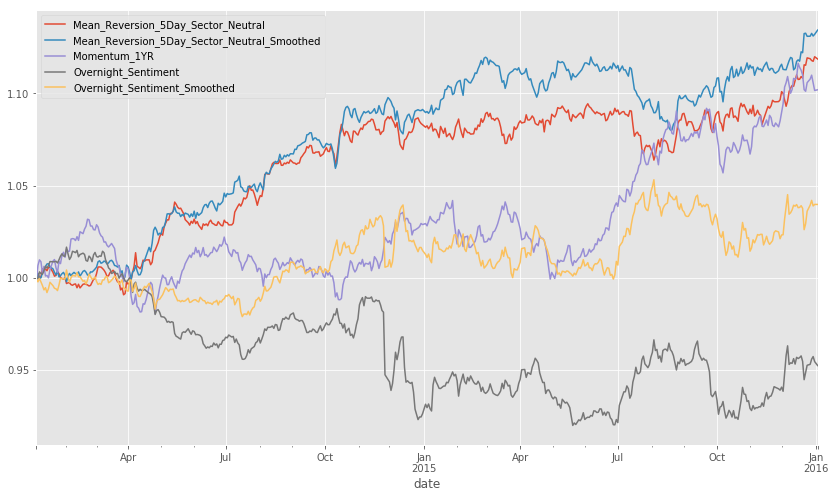

In [65]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot();

In [66]:
print('\nls_factor_returns:')
for factor, factor_data in ls_factor_returns.items():
    print(factor)


ls_factor_returns:
Mean_Reversion_5Day_Sector_Neutral
Mean_Reversion_5Day_Sector_Neutral_Smoothed
Momentum_1YR
Overnight_Sentiment
Overnight_Sentiment_Smoothed


In [67]:
ls_factor_returns['Momentum_1YR']

date
2014-01-06 00:00:00+00:00   -0.00101357
2014-01-07 00:00:00+00:00    0.00769780
2014-01-08 00:00:00+00:00    0.00298424
2014-01-09 00:00:00+00:00   -0.00101408
2014-01-10 00:00:00+00:00   -0.00623561
2014-01-13 00:00:00+00:00    0.00378638
2014-01-14 00:00:00+00:00   -0.00517092
2014-01-15 00:00:00+00:00    0.00025879
2014-01-16 00:00:00+00:00   -0.00128949
2014-01-17 00:00:00+00:00    0.00447803
2014-01-21 00:00:00+00:00    0.00462434
2014-01-22 00:00:00+00:00    0.00079968
2014-01-23 00:00:00+00:00   -0.00439244
2014-01-24 00:00:00+00:00   -0.00261616
2014-01-27 00:00:00+00:00    0.00602528
2014-01-28 00:00:00+00:00   -0.00116327
2014-01-29 00:00:00+00:00    0.00444457
2014-01-30 00:00:00+00:00    0.00165385
2014-01-31 00:00:00+00:00   -0.00269383
2014-02-03 00:00:00+00:00    0.00440524
2014-02-04 00:00:00+00:00   -0.00124439
2014-02-05 00:00:00+00:00    0.00018726
2014-02-06 00:00:00+00:00    0.00639857
2014-02-07 00:00:00+00:00    0.00026758
2014-02-10 00:00:00+00:00   -0.0001

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

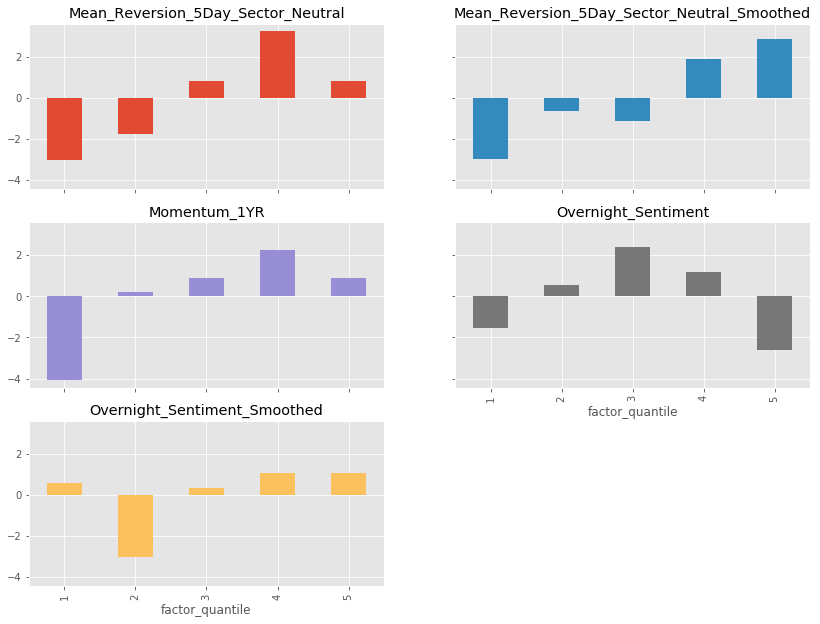

In [68]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

In [69]:
print('\nqr_factor_returns:')
for factor, factor_data in qr_factor_returns.items():
    print(factor)


qr_factor_returns:
Mean_Reversion_5Day_Sector_Neutral
Mean_Reversion_5Day_Sector_Neutral_Smoothed
Momentum_1YR
Overnight_Sentiment
Overnight_Sentiment_Smoothed


In [70]:
qr_factor_returns['Overnight_Sentiment']

factor_quantile
1   -0.00015346
2    0.00005368
3    0.00024121
4    0.00011811
5   -0.00025954
Name: Overnight_Sentiment, dtype: float64

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

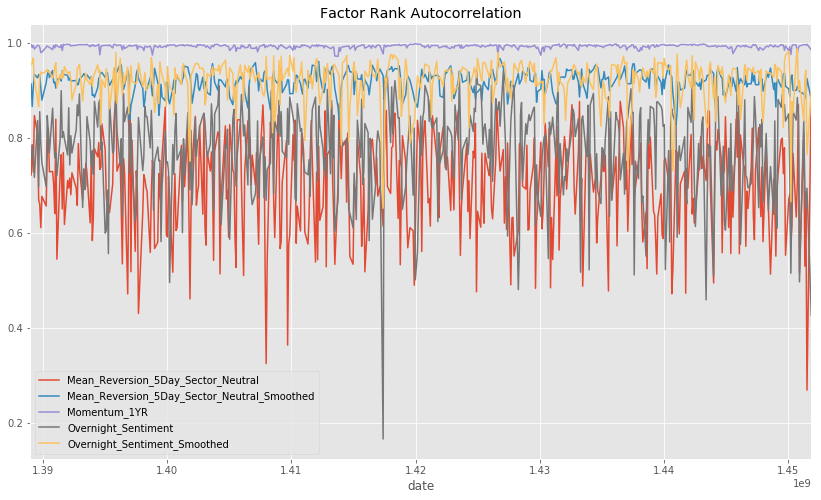

In [71]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation");

In [72]:
print('\nls_FRA:')
for factor, factor_data in ls_FRA.items():
    print(factor)


ls_FRA:
Mean_Reversion_5Day_Sector_Neutral
Mean_Reversion_5Day_Sector_Neutral_Smoothed
Momentum_1YR
Overnight_Sentiment
Overnight_Sentiment_Smoothed


In [73]:
ls_FRA['Overnight_Sentiment_Smoothed']

date
1388966400.00000000          nan
1389052800.00000000   0.95557469
1389139200.00000000   0.95677795
1389225600.00000000   0.96865287
1389312000.00000000   0.92194509
1389571200.00000000   0.88100810
1389657600.00000000   0.86581458
1389744000.00000000   0.92947511
1389830400.00000000   0.93888885
1389916800.00000000   0.93547765
1390262400.00000000   0.94059406
1390348800.00000000   0.94425443
1390435200.00000000   0.93849518
1390521600.00000000   0.94012601
1390780800.00000000   0.92578178
1390867200.00000000   0.93262526
1390953600.00000000   0.95013501
1391040000.00000000   0.95841584
1391126400.00000000   0.90760276
1391385600.00000000   0.93344134
1391472000.00000000   0.92488449
1391558400.00000000   0.94113576
1391644800.00000000   0.92709271
1391731200.00000000   0.95053105
1391990400.00000000   0.93563756
1392076800.00000000   0.93803780
1392163200.00000000   0.93952595
1392249600.00000000   0.92186596
1392336000.00000000   0.87999000
1392681600.00000000   0.91279928
     

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [74]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function
    return annualization_factor * np.mean(factor_returns) / np.std(factor_returns, ddof=1)


project_tests.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [75]:
daily_annualization_factor = np.sqrt(252)
sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [76]:
type(sharpe)

pandas.core.series.Series

In [77]:
sharpe

Mean_Reversion_5Day_Sector_Neutral             1.50000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed    1.69000000
Momentum_1YR                                   0.98000000
Overnight_Sentiment                           -0.41000000
Overnight_Sentiment_Smoothed                   0.42000000
dtype: float64

## Question: 

What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

### Student Answer:

Sharpe Ratio of 0.98 for momentum factor is good but if we look at the **Factor Rank Autocorrelation** plots, FRA for momentum factor looks stable. So smoothing the momentum factor will not have any significant change.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [78]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]

alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(0 [A]),-0.23184073
Equity(1 [AAL]),-0.37881334
Equity(3 [AAPL]),0.13986253
Equity(4 [ABBV]),-0.87454510
Equity(17 [AET]),1.27212870


In [79]:
# save intermediate data
# alpha_vector.to_csv('alpha_vector.csv')

# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [80]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [81]:
class OptimalHoldings(AbstractOptimalHoldings):
    
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        #return cvx.Minimize(-alpha_vector.T.values[0] * weights)
        return cvx.Maximize(np.array(alpha_vector.T) * weights)

    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        return [
            risk <= self.risk_cap ** 2,   
            factor_betas.T * weights <= self.factor_max,
            factor_betas.T * weights >= self.factor_min,
            sum(weights) == 0.0,
            sum(cvx.abs(weights)) <= 1.0,
            weights >= self.weights_min,
            weights <= self.weights_max        
        ]

    
    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

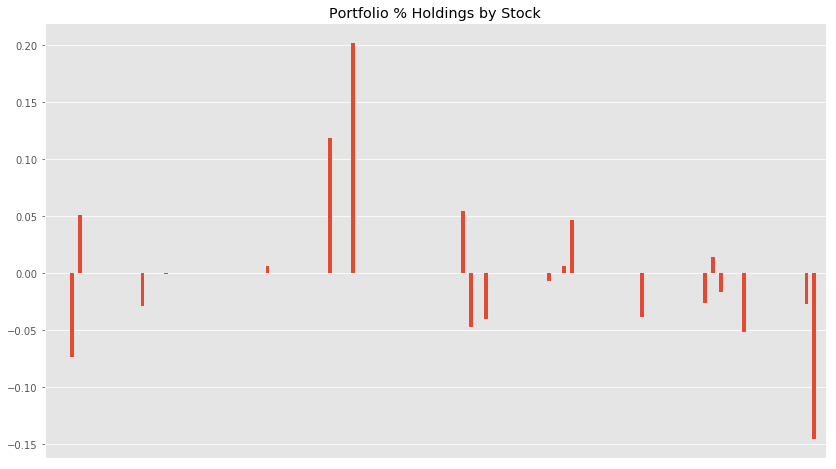

In [82]:
optimal_weights = OptimalHoldings().find(
    alpha_vector, 
    risk_model['factor_betas'], 
    risk_model['factor_cov_matrix'], 
    risk_model['idiosyncratic_var_vector']
)

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False);

Yikes. It put most of the weight in a few stocks.

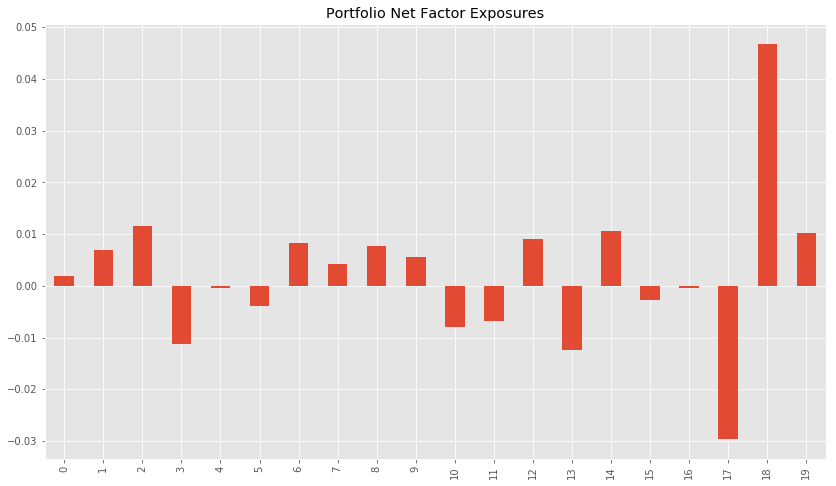

In [83]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [84]:
class OptimalHoldingsRegualization(OptimalHoldings):
    
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        return cvx.Maximize(np.array(alpha_vector.T) * weights - self.lambda_reg * cvx.norm(weights, 2))

    
    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

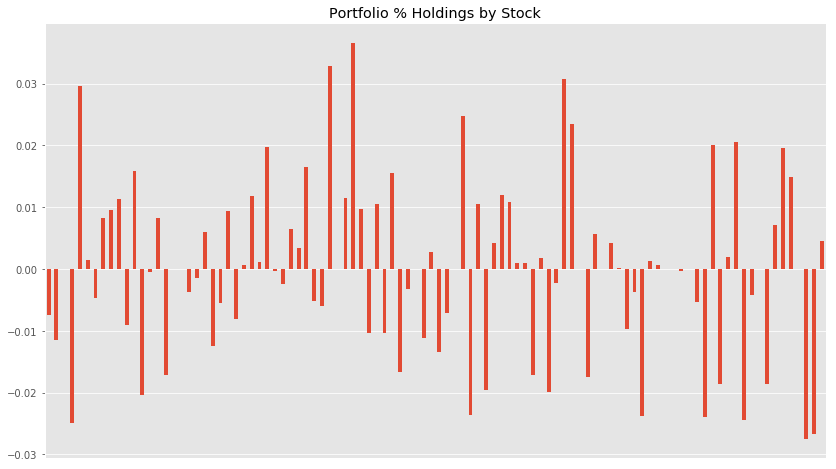

In [85]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False);

Nice. Well diversified.

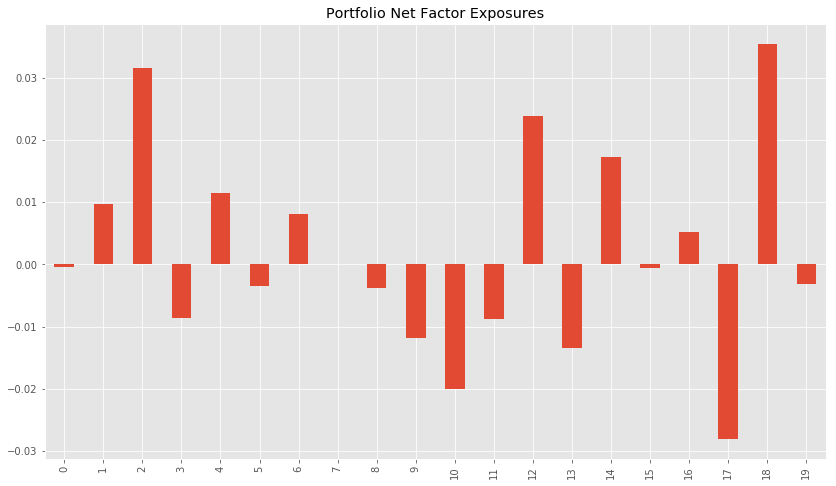

In [86]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [87]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        alpha_array = np.array(alpha_vector)
        alpha_mean = alpha_array.mean()

        x_ast = (alpha_array - alpha_mean) / (sum(abs(alpha_array)))
        x_ast = x_ast.reshape(len(x_ast))

        return cvx.Minimize(cvx.norm(weights - x_ast, 2))


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

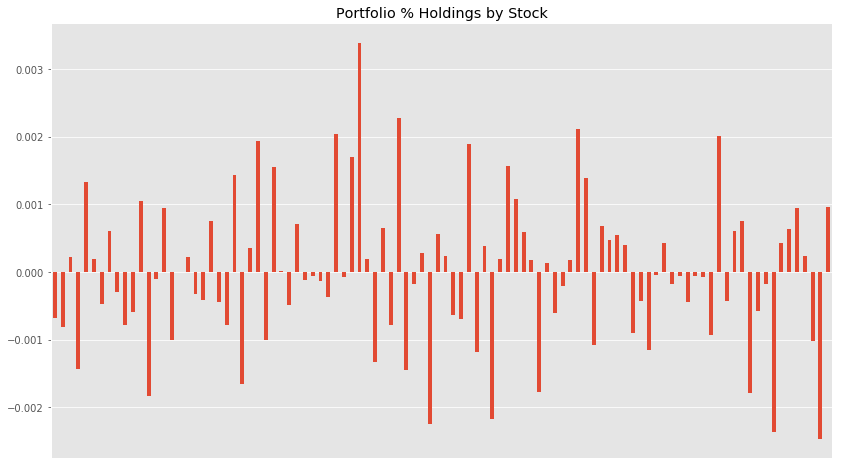

In [88]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015)\
    .find(
        alpha_vector, 
        risk_model['factor_betas'], 
        risk_model['factor_cov_matrix'], 
        risk_model['idiosyncratic_var_vector']
    )

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False);

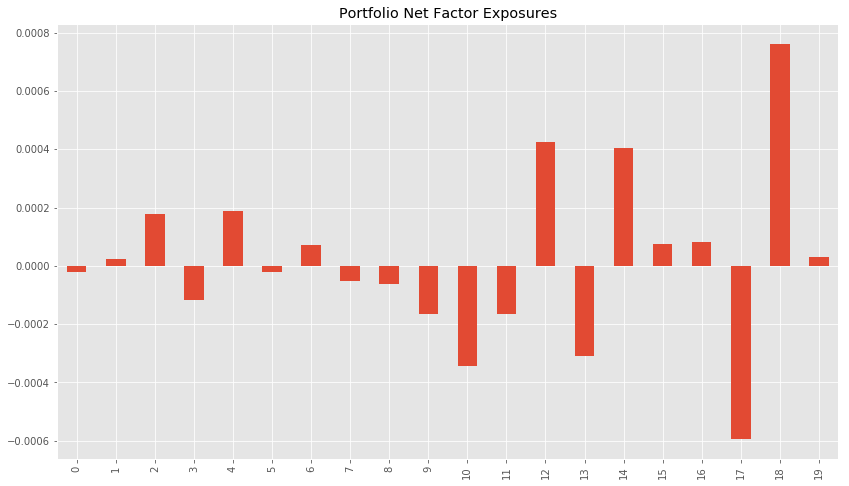

In [89]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False
);

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.